# TEXT CLASSIFICATION

This project tries to classify the text as positive or negative . 
The data set used is the sarcasm dataset . The dataset is present in the below format:

*   headline: text
*   is_sarcastic: label ( 0 or 1)
*   url: the url from where the article is retrieved


We shall use LSTM architecture to classify the sarcastic dataset. 
Lets use a pre-built embedding from the Glove Stanford embedding matrix




In [2]:
import tensorflow as tf
print (tf.__version__)


1.14.0


In [0]:
!pip install tensorflow==2.0.0-beta1 

In [1]:
import tensorflow as tf
print (tf.__version__)


2.0.0-beta1


In [0]:
import json
import tensorflow as tf
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [1]:
!wget --no-check-certificate \
   https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
   -O /tmp/sarcasm.json

--2019-07-29 09:36:07--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2019-07-29 09:36:07 (176 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
import json
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [0]:
with open('/tmp/sarcasm.json') as f:
    datastore =  json.load(f)

In [5]:
len(datastore)

26709

There are around 26K sentences to classify. Lets use 20K for training and the remaining for validation

In [0]:
sentences = []
labels    = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [16]:
print(len(sentences), len(labels))
print(sentences[15000], labels[15000])

26709 26709
5 important questions to ask about your audience before your next presentation 0


In [0]:
embedding_dim = 100
max_length = 32
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=20000

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(vocab_size)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_sequences = padded[:training_size]
training_labels = labels[:training_size]
test_sequences = padded[training_size:]
test_labels = labels[training_size:]




29656


In [22]:
print(vocab_size)
print(word_index['i'])


29656
79


In [23]:
# Note this is the 100 dimension version of GloVe from Stanford

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2019-07-29 10:04:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   108MB/s    in 3.1s    

2019-07-29 10:04:13 (108 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [24]:
print(len(embeddings_matrix))

29657


In [0]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])
    plt.figure()

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])
    plt.figure()

    
    


In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.2),                              
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 30
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           2965700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,050,309
Trainable params: 84,609
Non-trainable params: 2,965,700
_________________________________________________________________
Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 32s - loss: 0.4984 - accuracy: 

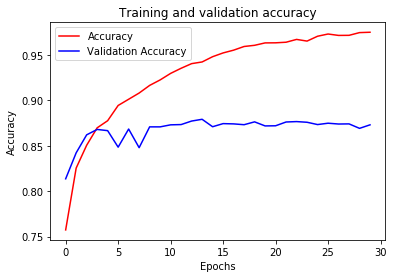

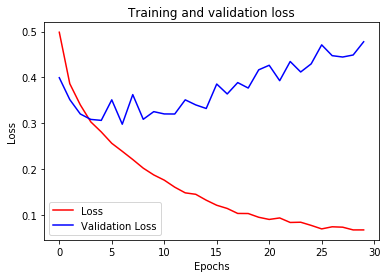

<Figure size 432x288 with 0 Axes>

In [30]:
plot_metrics(history)